# Step 2: SEM Fit Score

In [62]:
#| output: false

# Import the required packages
import pandas as pd
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import numpy as np
from datetime import datetime
import circumplex
import json
from scipy.spatial import procrustes
from tensorly.metrics.factors import congruence_coefficient

today = datetime.today().strftime('%Y-%m-%d')

In [63]:
#| warning: false

# Define the scales and angles to be used
scales = ["PAQ1", "PAQ2", "PAQ3", "PAQ4", "PAQ5", "PAQ6", "PAQ7", "PAQ8"]
eq_angles = [0, 45, 90, 135, 180, 225, 270, 315]

# Define the data and output folders
data_folder = Path("../data/")
output_folder = Path(f"../outputs/{today}")

# Load data
satp = pd.read_excel(data_folder / "SATP Dataset v1.4.xlsx")

lvls = pd.read_excel(data_folder / "LLAN.xlsx")
# Clean up the lvls data
lvls = lvls.groupby("Mark/Group Name").max().drop("Channel Name", axis=1)
lvls.rename(columns={"L/dB(SPL)": "max_Leq", "L(A)/dB(SPL)": "max_LAeq", "N/soneGF": "max_N", "L90(A)/dB(SPL)": "max_LA90"}, inplace=True)

# Add the levels to the satp data
satp = satp.merge(lvls, left_on="Recording", right_on = "Mark/Group Name", right_index=True)

# Load the results from the latest SEM analysis
sem_res = pd.read_csv(output_folder / "sem-fit-ipsatized.csv")
sem_res.drop("Unnamed: 0", axis=1, inplace=True)

# In some cases, the SEM flips the angles (i.e. vibrant is at 315 degrees instead of 45).
# This function checks for this and corrects it, to ensure all the scales are in the 
# correct order, but without changing the relationship between the angles, as identified by the SEM.)

# First, get the angles from the SEM results
ang_df = sem_res[sem_res['Model Type'] == 'Equal comm.'][["Language"] + scales]
ang_df.set_index("Language", inplace=True)


def check_inverse_angles(language_angles):
    """Check if the angles are inverse"""
    if language_angles[1] > language_angles[2] or language_angles[2] > language_angles[3]:
        return True
    else:
        return False

# Then, check if the angles are inverse, and if so, correct them
for lang in ang_df.index:
    if check_inverse_angles(ang_df.loc[lang].values):
        ang_df.loc[lang][1:] = 360 - ang_df.loc[lang][1:]

ang_dict = ang_df.T.to_dict(orient="list")
ang_dict

{'eng': [0.0, 46.0, 94.0, 138.0, 177.0, 231.0, 275.0, 340.0],
 'arb': [0.0, 36.0, 45.0, 135.0, 167.0, 201.0, 242.0, 308.0],
 'cmn': [0.0, 18.0, 38.0, 154.0, 171.0, 196.0, 217.0, 318.0],
 'deu': [0.0, 64.0, 97.0, 132.0, 182.0, 254.0, 282.0, 336.0],
 'ell': [0.0, 72.0, 86.0, 133.0, 161.0, 233.0, 267.0, 328.0],
 'fra': [0.0, 69.0, 102.0, 129.0, 173.0, 246.0, 275.0, 325.0],
 'hrv': [0.0, 84.0, 93.0, 160.0, 173.0, 243.0, 273.0, 354.0],
 'ind': [0.0, 53.0, 104.0, 123.0, 139.0, 202.0, 284.0, 308.0],
 'ita': [0.0, 57.0, 104.0, 142.0, 170.0, 274.0, 285.0, 336.0],
 'jpn': [0.0, 46.0, 101.0, 138.0, 159.0, 271.0, 288.0, 339.0],
 'kor': [0.0, 56.0, 90.0, 124.0, 151.0, 251.0, 275.0, 288.0],
 'nld': [0.0, 43.0, 111.0, 125.0, 174.0, 257.0, 307.0, 341.0],
 'por': [0.0, 81.0, 121.0, 140.0, 171.0, 252.0, 275.0, 334.0],
 'spa': [0.0, 41.0, 103.0, 147.0, 174.0, 238.0, 279.0, 332.0],
 'swe': [0.0, 66.0, 87.0, 146.0, 175.0, 249.0, 275.0, 335.0],
 'tur': [0.0, 55.0, 97.0, 106.0, 157.0, 254.0, 289.0, 313.0]}

In [140]:
ang_dict['eng']

[0.0, 46.0, 94.0, 138.0, 177.0, 231.0, 275.0, 340.0]

### Calculate the SEM fit score

The SEM fit score is calculated by counting the number of fit indices that pass the pre-defined threshold. The thresholds are defined in the first part of the code. The thresholds are based on the thresholds used by @Rogoza2021three.

The first part of the code defines a dictionary named `thresholds` which contains the thresholds for different fit criteria used in SEM. These criteria include p-value (p), Comparative Fit Index (CFI), Goodness of Fit Index (GFI), Adjusted Goodness of Fit Index (AGFI), Standardized Root Mean Square Residual (SRMR), and others.

The `incl_in_score` list is used to select which criteria will be included in the final score calculation. The `pass_thresh` and `tent_thresh` variables define the thresholds for passing and tentative passing scores, respectively.

The next part of the code calculates whether each SEM result passes the defined thresholds for each criterion. This is done by comparing the SEM result for each criterion to its respective threshold. The results of these comparisons are stored as boolean values in new columns in the `sem_res` DataFrame.

The final score for each SEM result is then calculated by summing the number of criteria each result passes. This score is stored as an integer in a new column in the `sem_res` DataFrame. The passing column categorizes each SEM result as 'Fail', 'Tentative', or 'Pass' based on its final score.

Finally, the results are saved to an Excel file and a subset of the results is displayed. The subset includes only the results for the "Equal comm." model type and is sorted by score in descending order.

In [65]:
# Define the thresholds for the SEM fit criteria
thresholds = {
    "p": 0.05,
    "CFI": 0.92, #  Moshona et al 2023
    # "CFI": 0.9, # Rogoza 2021
    # "CFI": 0.95, # Good fit from Tarlao et al 2021, but 0.90 is considered acceptable
    "GFI": 0.9,  # Rogoza 2021
    "AGFI": 0.85, # Rogoza 2021
    "SRMR": 0.08, # Moshona et al 2023, Tarlao et al 2021
    # "MCSC": -0.7,
    # "RMSEA": 0.08, # Moshona et al 2023
    # "RMSEA": 0.05, # Tarlao et al 2021
    # "RMSEA": 0.13, # Rogoza says this is might be reasonable
    # Removed RMSEA at the suggestion of West, S.G., Wu, W., McNeish, D., & Savord, A. (2023). Model Fit in Structural Equation Modeling. In R.H. Hoyle, Handbook of structural equation modeling, second edition (pp. 185-205). New York, NY: Guilford
    # "GDIFF": 25,
}

# Choose which criteria to include in the final score
# incl_in_score = ['CFI', 'GFI', 'SRMR', 'MCSC'] # ours
# incl_in_score = ['CFI', 'GFI', 'AGFI', 'RMSEA'] # Rogoza
incl_in_score = ['CFI', 'GFI', 'SRMR'] # mixed

# Define the thresholds for the final score
pass_thresh = 3

# Calculate the final score
# sem_res['p_pass'] = sem_res['p'] <= thresholds['p']
sem_res['CFI_pass'] = sem_res['CFI'] >= thresholds['CFI']
sem_res['GFI_pass'] = sem_res['GFI'] >= thresholds['GFI']
# sem_res['AGFI_pass'] = sem_res['AGFI'] >= thresholds['AGFI']
sem_res['SRMR_pass'] = sem_res['SRMR'] <= thresholds['SRMR']
# sem_res['MCSC_pass'] = sem_res['MCSC'] <= thresholds['MCSC']
# sem_res['RMSEA_pass'] = sem_res['RMSEA'] <= thresholds['RMSEA']
# sem_res['GDIFF_pass'] = sem_res['GDIFF'] <= thresholds['GDIFF']

sem_res['Score'] = sem_res[[x + '_pass' for x in incl_in_score]].sum(axis=1)
sem_res['Score'] = sem_res['Score'].astype(int)
sem_res['passing'] = pd.cut(sem_res['Score'], bins=[0, pass_thresh, 7], labels=['Fail', 'Pass'], right=False)
# Save the results
# sem_res.to_excel(output_folder / f"{today}_sem-fit-results-Rogoza.xlsx", index=False)


In [66]:
#| label: tbl-sem-res
#| tbl-cap: SEM fit results

sem_res[["Language", "Model Type", "n", "m", "CFI", "GFI", "SRMR", "Score", "passing"]].loc[sem_res["Model Type"] == "Equal comm."].sort_values("Score", ascending=False)

,Language,Model Type,n,m,CFI,GFI,SRMR,Score,passing
1,eng,Equal comm.,864,3,0.93,0.91,0.05,3,Pass
5,arb,Equal comm.,809,3,0.97,0.97,0.04,3,Pass
9,cmn,Equal comm.,1832,3,0.96,0.95,0.04,3,Pass
13,deu,Equal comm.,810,3,0.94,0.92,0.06,3,Pass
17,ell,Equal comm.,810,3,0.93,0.93,0.08,3,Pass
25,hrv,Equal comm.,864,3,0.95,0.93,0.06,3,Pass
29,ind,Equal comm.,891,3,0.93,0.92,0.08,3,Pass
33,ita,Equal comm.,810,3,0.94,0.93,0.07,3,Pass
41,kor,Equal comm.,810,3,0.95,0.94,0.08,3,Pass
45,nld,Equal comm.,864,3,0.97,0.94,0.06,3,Pass


In [67]:
# Perform the SSM analysis
passing = sem_res.loc[sem_res["Model Type"] == "Equal comm."].query("passing != 'Fail'")['Language'].values

satp = satp.query("Language in @passing")

### Step two: Locating external variables in the circumplex

For this analysis, we use a custom Python package developed for this paper, called `circumplex` which can be installed from PyPI.

### Step 3: Accurately locating circumplex items within each language

The final step of @Rogoza2021three 's three step procedure is to test the congruence between the empirical locations and theoretical expectations within the circumplex structure. In the case of the soundscape circumplex and our SATP data, we don't have an external variable with a defined theoretical location within the circumplex - for instance loudness does not have a defined location within the circumplex where it is expected to be located.

Taking inspiration from @Yik2004Relationships, we propose to use the circumplex structure of the soundscape survey itself as the theoretical expectation. @Yik2004Relationship proposes that one circumplex can be located within another by calculating the SSM correlation between each of the scales of the reference circumplex and the test circumplex. In this way, each scale of the reference circumplex can be located within the test circumplex, and we can test whether these empirical locations meet our expectations.

The process to do this is as follows:

1.  For both the reference and test circumplex, calculate the mean value of each scale for each recording.
2.  Calculate the SSM correlation between each scale of the reference circumplex and the test circumplex, in our case using the corrected angles.
3.  Test the congruence betwen the empirical locations and theoretical expectations using the Procrustes congruence test [@Rogoza2021three].

We will be using the full dataset as the reference set and the data from each translation as the test set. This effectively means that we are testing whether each translation is able to locate the circumplex structure of the soundscape survey, consistently across all languages.

This aligns with the overall goal of our process of allowing data (i.e. the circumplex coordinate) from different languages to be directly compared, by correcting for the differences in the circumplex structure between languages.

> to minimize $M^2 = \sum (data1 - data2)^2$ , or the sum of the squares of the pointwise differences between the two input datasets.

#### Congruence

What @Rogoza2021three (and Orthosim) refer to as Tucker's Congruence Coefficient is also commonly referred to as the cosine similarity (see the [Tensorly documentation](https://tensorly.org/stable/modules/generated/tensorly.metrics.factors.congruence_coefficient.html)). We therefore use the sklearn implementation of cosine similarity to calculate the congruence between the empirical locations and theoretical expectations. This produces a matrix of cosine similarity values, which we then use to calculate the mean congruence, to match the model congruence from @Rogoza2021three.

We can confirm the equivalence of this method by comparing with the results from @Rogoza2021three 's Orthosim analysis:

In [68]:
def congruence(data1, data2, metric: ['cosine', 'euclidean']='cosine'):
    from sklearn.metrics.pairwise import cosine_similarity
    from scipy.spatial.distance import cdist

    if metric == 'cosine':
        sim = cosine_similarity(data1, data2)
    elif metric == 'euclidean':
        sim = 1 - cdist(data1, data2, metric=metric)
    else:
        raise ValueError("metric must be 'cosine' or 'euclidean'")
    cong_vals = np.diag(sim) # Get the diagonal values which compare against the appropriate angles
    return np.mean(cong_vals), cong_vals

# Data from Rogoza
data2 = np.array([[-0.59, -0.8], [-1, -0.05], [-0.5, 0.87]])
data1 = np.array([[-0.71, -0.71], [-1, 0], [-0.71, 0.71]])

model_congruence, scale_congruence = congruence(data1, data2)

print("Model Congruence == 0.984: ", np.round(model_congruence, 3) == 0.984)
print("Vulnerability Congruence == 0.99: ", np.round(scale_congruence[0], 2) == 0.99)
print("Antagonism Congruence == 1.0: ", np.round(scale_congruence[1], 2) == 1.0)
print("Grandiosity Congruence == 0.97: ", np.round(scale_congruence[2], 2) == 0.97)

Model Congruence == 0.984:  True
Vulnerability Congruence == 0.99:  True
Antagonism Congruence == 1.0:  True
Grandiosity Congruence == 0.97:  True


#### Procrustes

However, it appears that, despite @Rogoza2021three 's description, this method is not actually based on a Procrustes analysis. The equivalent distance metric from a Procrustes method would be the rotational-based Procrustes distance, i.e. the squared Froebenius norm of the difference between the two orthogonal matrices. See @Andreella2023Procrustes:

> Instead, the second distance exploits the orthogonal matrix parameters solution of the Procrustes problem. The rotational-based distance computes the squared Frobenius distance between these estimated orthogonal matrices. As we will see, this metric measures the level of dissimilarity/similarity in orientation between matrices/subjects before functional alignment.

As such, we can also calculate this distance using the [`procrustes` package](https://procrustes.qcdevs.org/api/utils.html#procrustes.utils.ProcrustesResult):

In [69]:
def procrustes_distance(data1, data2, procrustes_type='orthogonal', translate=True, scale=True):
    if procrustes_type == 'orthogonal':
        from procrustes import orthogonal
        pro_res = orthogonal(data1, data2, translate=translate, scale=scale)
    elif procrustes_type == 'rotational':
        from procrustes import rotational
        pro_res = rotational(data1, data2, translate=translate, scale=scale)
    elif procrustes_type == 'generic':
        from procrustes import generic
        pro_res = generic(data1, data2, translate=translate, scale=scale)
    return pro_res.error

In [70]:
def prepare_congruence_matrices(ssm_table, target_angles = eq_angles):
    """Prepare the congruence matrices for the SSM results"""
    # Get the data from the SSM table
    # data2 = np.array((np.cos(np.deg2rad(ssm_table['displacement'])), np.sin(np.deg2rad(ssm_table['displacement'])))).T
    data2 = ssm_table[['xval', 'yval']].values
    # Get the data from the target angles
    data1 = np.ones_like(data2)
    data1[:, 0] = np.cos(np.deg2rad(target_angles))
    data1[:, 1] = np.sin(np.deg2rad(target_angles))

    return data1, data2

Based on the proof given in @Baktiar2015symmetrical, given that the input matrices are scaled (i.e. `rotational(scale=True)`), then the Procrustes distance is a true distance measure which obeys $0 < p(X, Y) < 1$ [@Bakhtiar2015symmetrical, 322]. Therefore we can convert the Procrustes distance to a similarity measure by subtracting it from 1.

In [71]:
overall_means = satp.groupby(["Recording"])[scales].mean().reset_index(drop=True)

lang_rec_means = satp.groupby(["Language", "Recording"])[scales].mean()
lang_rec_means.reset_index(inplace=True)

def test_language_locations(test_lang_means, test_lang, test_angles, target_angles=eq_angles, scales=('PAQ1', 'PAQ2', 'PAQ3', 'PAQ4', 'PAQ5', 'PAQ6', 'PAQ7', 'PAQ8')):
    """Test the congruence of the language locations with the target angles"""
    # test_lang_means = lang_rec_means.query("Language == @test_lang")[scales].reset_index(drop=True)
    test_res = []
    for scale in scales:
        corrs = test_lang_means.corrwith(overall_means[scale])
        ssm_res = circumplex.SSMParams(
            corrs,
            scales,
            test_angles,
            scale,
        )
        test_res.append(ssm_res)

    test_ssm = circumplex.SSMResults(test_res)

    data1, data2 = prepare_congruence_matrices(test_ssm.table, target_angles=target_angles)
    test_model_congruence, test_scale_congruences = congruence(data1, data2, metric='cosine')
    pro_sim = 1 - procrustes_distance(data1, data2, procrustes_type='rotational')
    return test_ssm, test_model_congruence, test_scale_congruences, pro_sim

locating_corr_angles = {}
locating_eq_angles = {}
for test_lang in lang_rec_means.Language.unique():
    test_lang_means = lang_rec_means.query("Language == @test_lang")[scales].reset_index(drop=True)

    locating_eq_angles[test_lang] = test_language_locations(test_lang_means, test_lang, test_angles=eq_angles, target_angles=eq_angles)
    locating_corr_angles[test_lang] = test_language_locations(test_lang_means, test_lang, test_angles=ang_dict[test_lang], target_angles=eq_angles)

In [72]:
#| label: tbl-corr-angles-fit
#| tbl-cap: Fit results for locating the general circumplex within each language
fit_results = pd.DataFrame.from_dict({key: locating_corr_angles[key][0].table.r2 for key in locating_corr_angles.keys()}).T
fit_results.round(3)

,PAQ1,PAQ2,PAQ3,PAQ4,PAQ5,PAQ6,PAQ7,PAQ8
arb,0.998,0.999,0.995,0.995,0.998,0.999,0.997,0.995
cmn,0.997,0.996,0.988,0.993,0.999,0.999,0.989,0.992
deu,0.998,0.999,0.999,0.998,0.998,0.998,0.999,0.998
ell,0.998,0.995,0.998,0.998,0.997,0.998,0.996,0.997
eng,0.997,0.998,0.999,0.996,0.997,0.999,0.998,0.994
hrv,0.997,0.997,0.994,0.995,0.997,0.998,0.995,0.991
ind,0.996,0.998,0.998,0.998,0.996,0.993,0.999,0.996
ita,0.892,0.996,0.998,0.986,0.980,0.991,0.996,0.977
kor,0.997,0.996,0.996,0.998,0.998,0.991,0.997,0.998
nld,0.993,0.999,0.999,0.998,0.998,0.996,0.999,0.999


In [73]:
#| label: tbl-correspondence
#| tbl-cap: Correspondence between the general circumplex and the language-specific circumplex

congruence_df = pd.DataFrame(
    {
        "Language": list(locating_eq_angles.keys()),
        "Eq Ang Model": [x[1] for x in locating_eq_angles.values()],
        "Corr Ang Model": [x[1] for x in locating_corr_angles.values()],
        "Eq Ang Procrustes": [x[3] for x in locating_eq_angles.values()],
        "Corr Ang Procrustes": [x[3] for x in locating_corr_angles.values()],
    }
)
congruence_df.round(3)

,Language,Eq Ang Model,Corr Ang Model,Eq Ang Procrustes,Corr Ang Procrustes
0,arb,0.992,0.943,0.982,0.982
1,cmn,0.932,0.993,0.885,0.991
2,deu,0.985,0.957,0.973,0.983
3,ell,0.985,0.989,0.970,0.979
4,eng,0.988,0.977,0.983,0.983
5,hrv,0.990,0.969,0.982,0.985
6,ind,0.965,0.951,0.935,0.982
7,ita,0.984,0.952,0.974,0.975
8,kor,0.958,0.977,0.921,0.975
9,nld,0.978,0.972,0.939,0.978


We can see from the above table that the congruence between the empirical locations and theoretical expectations is quite high for all languages. In addition, by using the corrected angles, we can see that the procrustes similarity is improved for nearly all languages (slight decrease for 'ita').

Below, we can show that this looks like in practice. The first plot shows the empirical locations of the scales for the Mandarin translation, using the equal angles. The second plot shows the empirical locations of the scales for the Mandarin translation, using the corrected angles.

In [328]:
locating_corr_angles['cmn'][0].results

[SSMParams(PAQ1, scores=PAQ1    0.960452
 PAQ2    0.800339
 PAQ3    0.668952
 PAQ4   -0.876819
 PAQ5   -0.952681
 PAQ6   -0.877661
 PAQ7   -0.763064
 PAQ8    0.744689
 dtype: float64, angles=[0.0, 18.0, 38.0, 154.0, 171.0, 196.0, 217.0, 318.0]),
 SSMParams(PAQ2, scores=PAQ1    0.734378
 PAQ2    0.917424
 PAQ3    0.894592
 PAQ4   -0.256684
 PAQ5   -0.581538
 PAQ6   -0.839557
 PAQ7   -0.908550
 PAQ8    0.006320
 dtype: float64, angles=[0.0, 18.0, 38.0, 154.0, 171.0, 196.0, 217.0, 318.0]),
 SSMParams(PAQ3, scores=PAQ1    0.144705
 PAQ2    0.504049
 PAQ3    0.634427
 PAQ4    0.341486
 PAQ5    0.002668
 PAQ6   -0.374269
 PAQ7   -0.549625
 PAQ8   -0.517605
 dtype: float64, angles=[0.0, 18.0, 38.0, 154.0, 171.0, 196.0, 217.0, 318.0]),
 SSMParams(PAQ4, scores=PAQ1   -0.609359
 PAQ2   -0.266204
 PAQ3   -0.109054
 PAQ4    0.868897
 PAQ5    0.710570
 PAQ6    0.405468
 PAQ7    0.202097
 PAQ8   -0.902366
 dtype: float64, angles=[0.0, 18.0, 38.0, 154.0, 171.0, 196.0, 217.0, 318.0]),
 SSMParams(PAQ5,

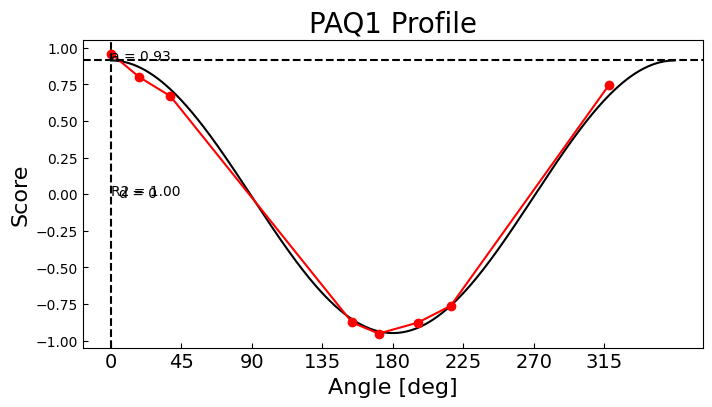

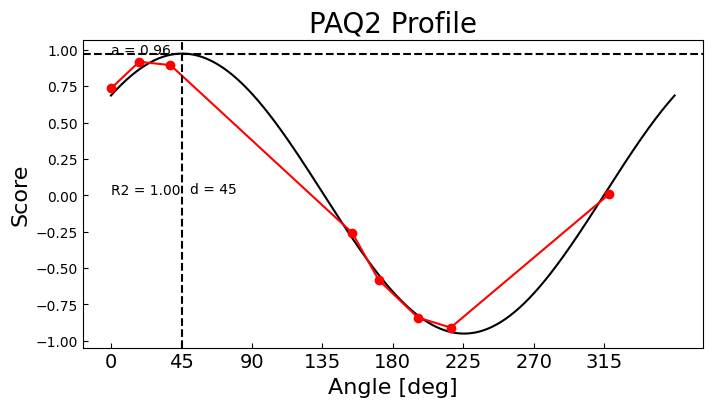

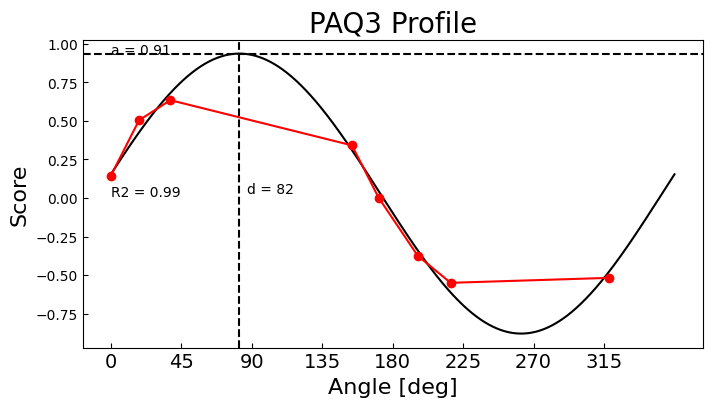

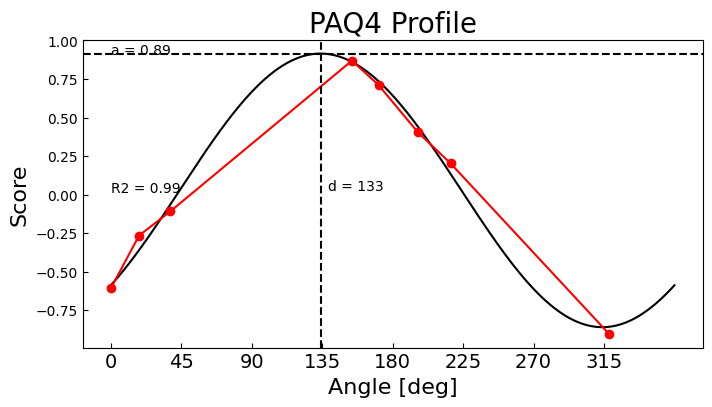

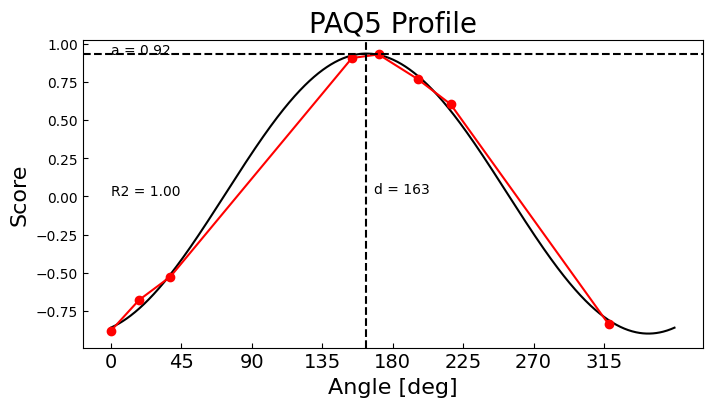

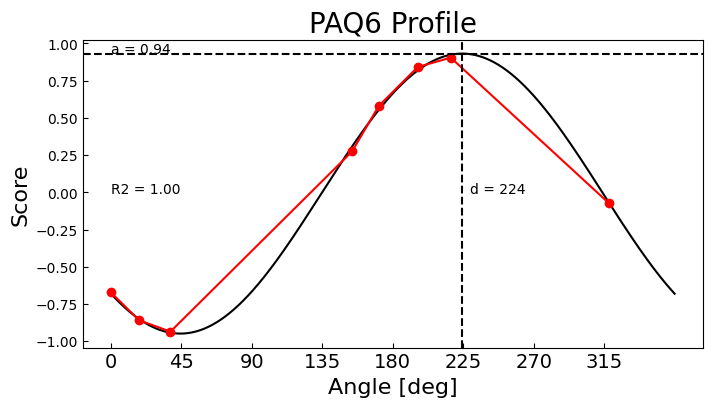

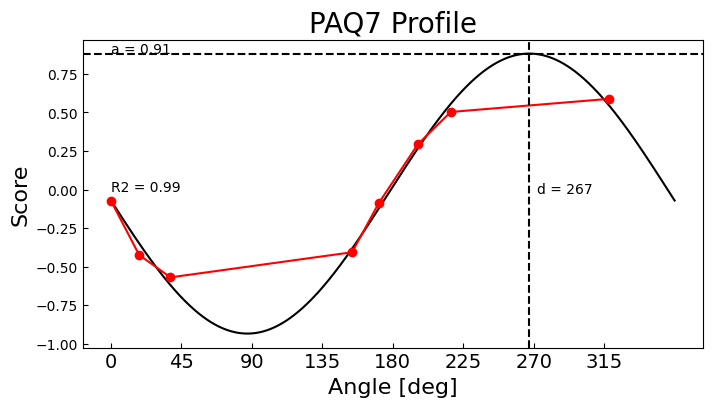

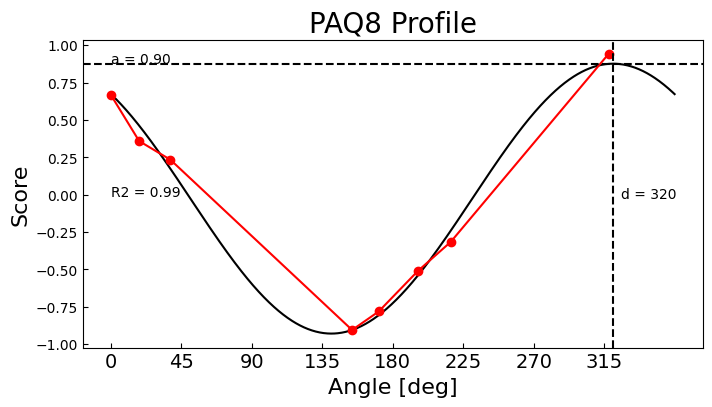

In [330]:
#| label: fig-profile-plots
#| fig-cap: Profile plots for the Mandarin (cmn) translation
#| layout-nrow: 2
#| layout-ncol: 4
#| fig-subcap: 
#|   - PAQ1
#|   - PAQ2
#|   - PAQ3
#|   - PAQ4
#|   - PAQ5
#|   - PAQ6
#|   - PAQ7
#|   - PAQ8

for res in locating_corr_angles['cmn'][0].results:
    res.profile_plot()
    plt.show()



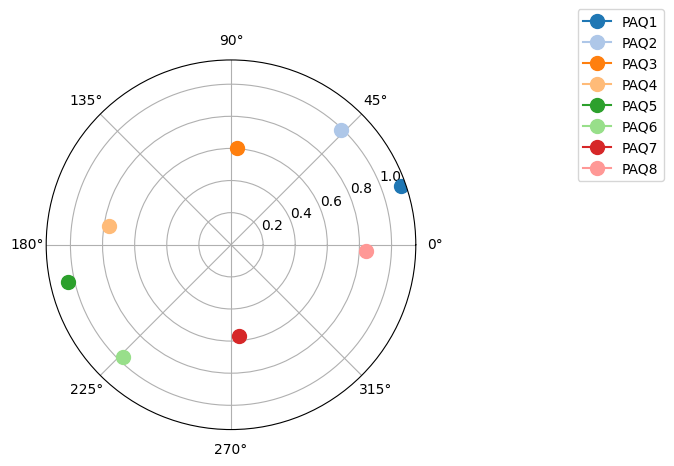

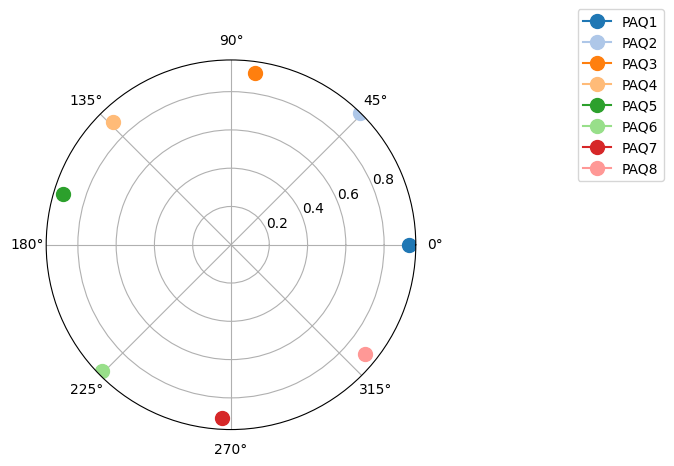

In [74]:
#| label: fig-cmn-correspondence
#| layout-ncol: 2
#| fig-cap: "Locating the  language-specific circumplex for Mandarin, using equal angles and corrected angles"
#| fig-subcap: 
#|   - "Equal angles"
#|   - "Corrected angles"

locating_eq_angles['cmn'][0].plot()
plt.show()
locating_corr_angles['cmn'][0].plot()
plt.show()

While the relative locations of the scales around the circumplex are not perfect, it can be clearly seen that when the correction is applied, the scales are much more closely located to the theoretical expectations. Since this is true across all of the languages, we can now have the expectation that we are working within a consistent circumplex space. This means that we can directly compare the circumplex coordinates between languages, and that any differences in the circumplex coordinates are due to differences in the soundscape perception, rather than differences in the circumplex structure of the translation.

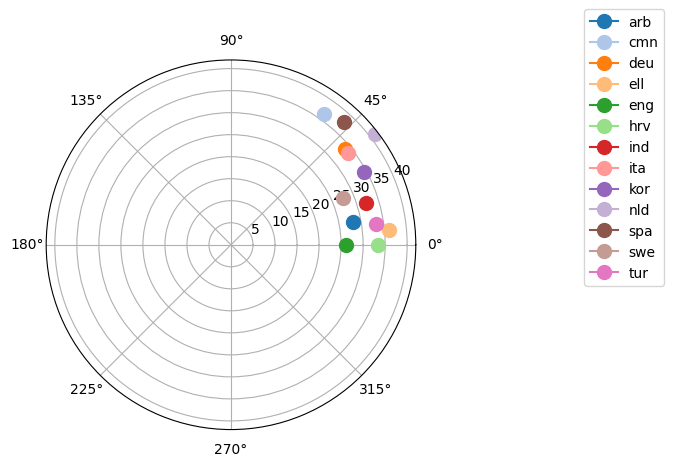

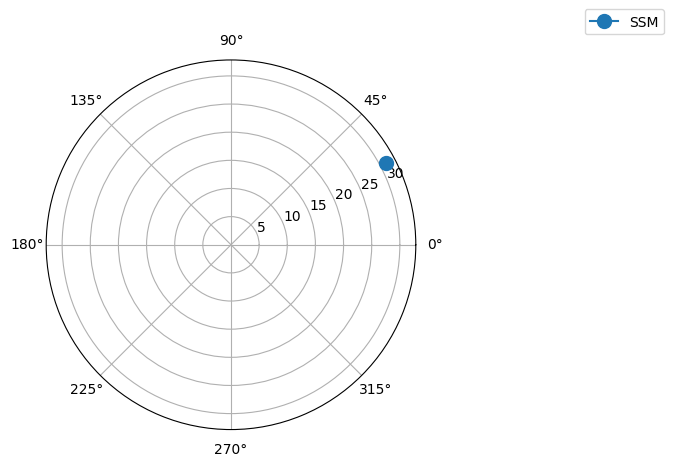

In [75]:
cg01_res = circumplex.ssm_analyse(satp.query("Recording == 'CG01'"), scales, grouping=['Language'], grouped_angles=ang_dict)
cg01_all = circumplex.ssm_analyse(satp.query("Recording == 'CG01'"), scales)

cg01_res.plot()
plt.show()
cg01_all.plot()
plt.show()

## Soundscapy for full languages



In [294]:
ang_dict.keys()

dict_keys(['eng', 'arb', 'cmn', 'deu', 'ell', 'fra', 'hrv', 'ind', 'ita', 'jpn', 'kor', 'nld', 'por', 'spa', 'swe', 'tur'])

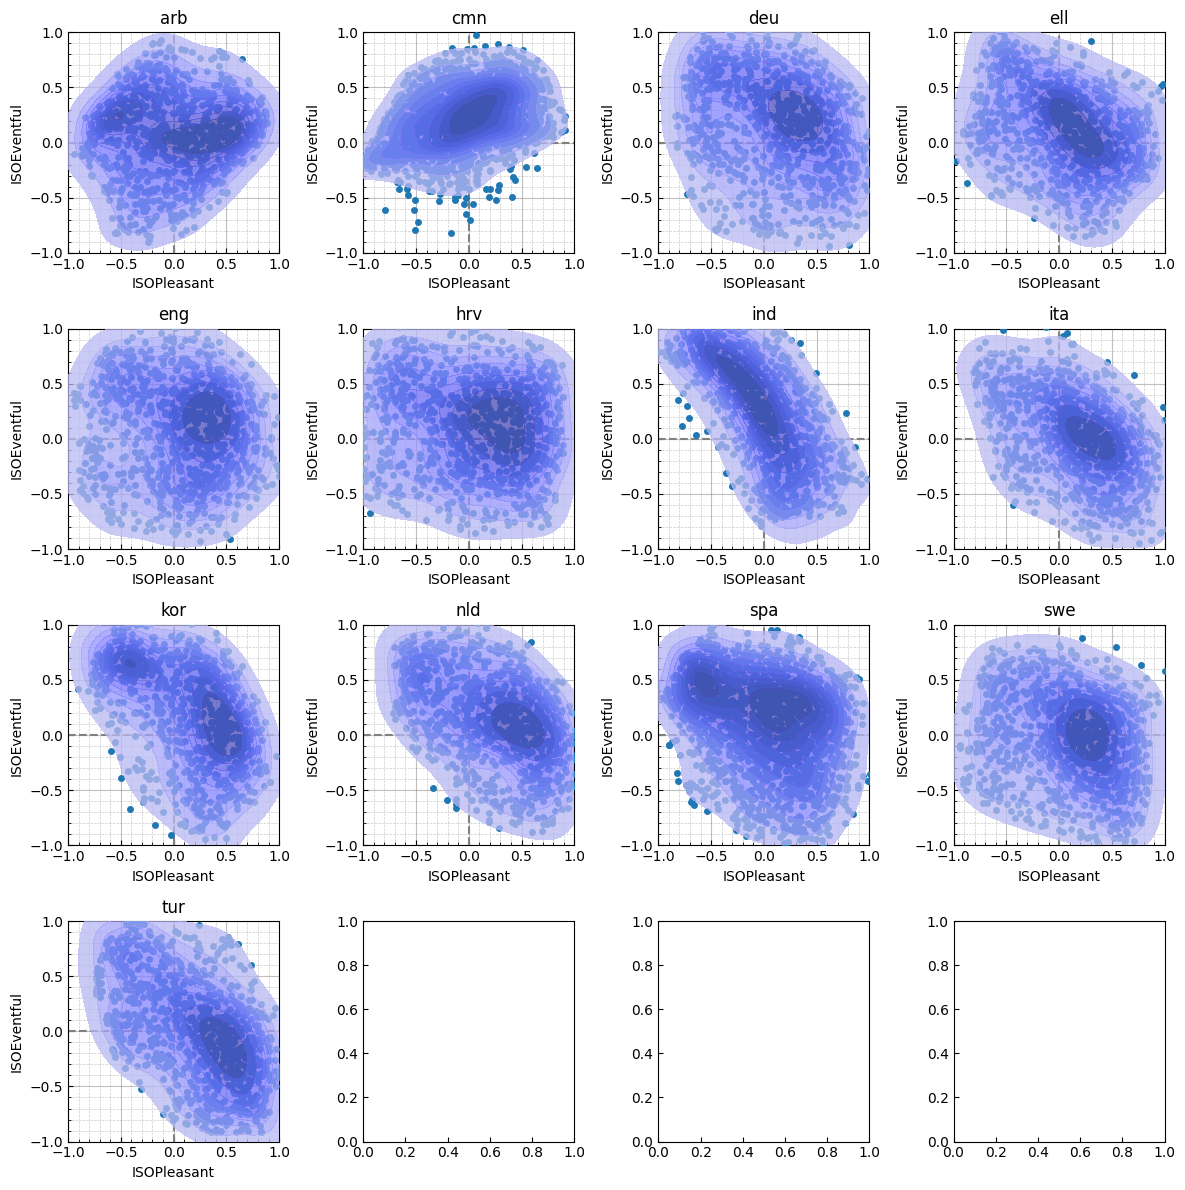

In [316]:
import soundscapy as sspy

def adj_angle_iso_coords(data: pd.DataFrame, angles, scale=100):
    isopl = data.apply(lambda x: adj_iso_pl(x[scales].values, angles, scale=scale), axis=1)
    isoev = data.apply(lambda x: adj_iso_ev(x[scales].values, angles, scale=scale), axis=1)
    return isopl, isoev

def adj_iso_pl(values, angles, scale=None):
    # scale = range of input values (e.g. 0-100)
    # The scaling factor was derived by comparing to the scaling from the ISO method. Confirmed to be the same value when using equal angles
    # 100 * sum of abs values of the loading factors / 2
    iso_pl = np.sum([np.cos(np.deg2rad(angle)) * values[i] for i, angle in enumerate(angles)])
    if scale:
        iso_pl = iso_pl / (scale/2 * np.sum(np.abs([np.cos(np.deg2rad(angle)) for angle in angles])))
    return iso_pl

def adj_iso_ev(values, angles, scale=None):
    iso_ev = np.sum([np.sin(np.deg2rad(angle)) * values[i] for i, angle in enumerate(angles)])
    if scale:
        iso_ev = iso_ev / (scale/2 * np.sum(np.abs([np.sin(np.deg2rad(angle)) for angle in angles])))
    return iso_ev

fig, axes = plt.subplots(4, 4, figsize=(12, 12))
for i, lang in enumerate(satp.Language.unique()):
    lang_data = satp.query("Language == @lang")
    isopl, isoev = adj_angle_iso_coords(lang_data, ang_dict[lang], scale=100)
    lang_res = pd.DataFrame({"ISOPleasant": isopl, "ISOEventful": isoev})
    sspy.plotting.density(lang_res, ax=axes.flatten()[i], title=lang)

plt.tight_layout()



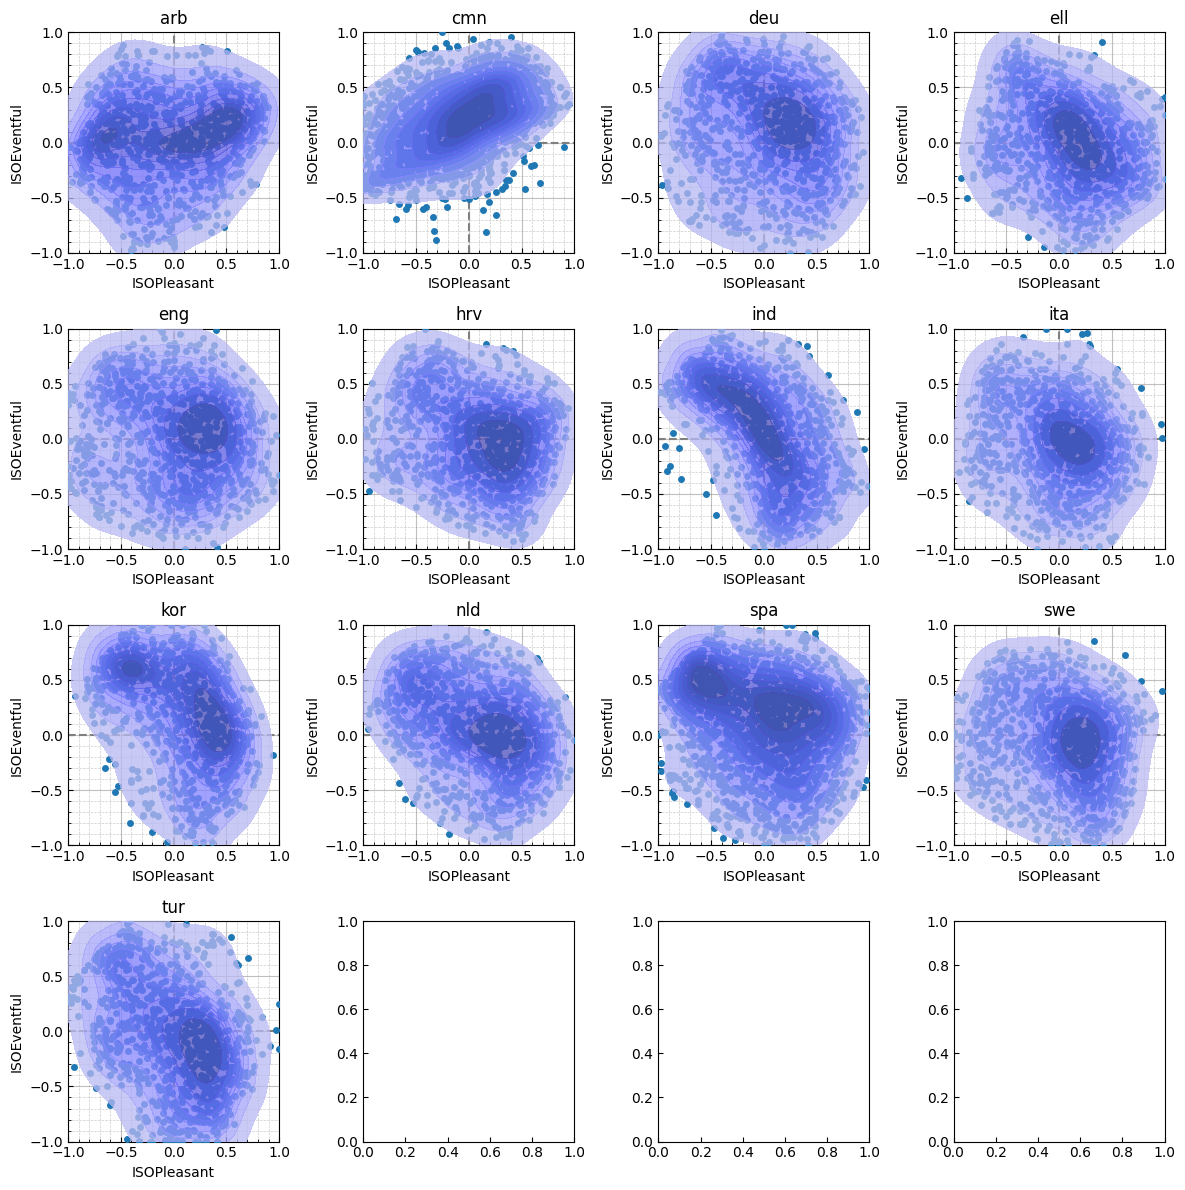

In [317]:
fig, axes = plt.subplots(4, 4, figsize=(12, 12))
for i, lang in enumerate(satp.Language.unique()):
    lang_data = satp.query("Language == @lang")
    isopl, isoev = adj_angle_iso_coords(lang_data, eq_angles, scale=100)
    # isopl, isoev = sspy.surveys.calculate_paq_coords(lang_data, val_range=(0,100))
    lang_res = pd.DataFrame({"ISOPleasant": isopl, "ISOEventful": isoev})
    sspy.plotting.density(lang_res, ax=axes.flatten()[i], title=lang)

plt.tight_layout()

arb
ISOPleasant   -0.724731
ISOEventful   -0.734312
dtype: float64
ISOPleasant    0.853723
ISOEventful    0.857112
dtype: float64
cmn
ISOPleasant   -0.747826
ISOEventful   -0.788152
dtype: float64
ISOPleasant    0.801564
ISOEventful    0.801375
dtype: float64
deu
ISOPleasant   -0.681674
ISOEventful   -0.820749
dtype: float64
ISOPleasant    0.870961
ISOEventful    0.863928
dtype: float64
ell
ISOPleasant   -0.808539
ISOEventful   -0.657042
dtype: float64
ISOPleasant    0.862117
ISOEventful    0.942375
dtype: float64
eng
ISOPleasant   -0.766481
ISOEventful   -0.780471
dtype: float64
ISOPleasant    0.875728
ISOEventful    0.897991
dtype: float64
hrv
ISOPleasant   -0.903007
ISOEventful   -0.727908
dtype: float64
ISOPleasant    0.784467
ISOEventful    0.964066
dtype: float64
ind
ISOPleasant   -0.805723
ISOEventful   -0.552141
dtype: float64
ISOPleasant    0.724701
ISOEventful    1.019397
dtype: float64
ita
ISOPleasant   -0.596112
ISOEventful   -0.765819
dtype: float64
ISOPleasant    0.929763

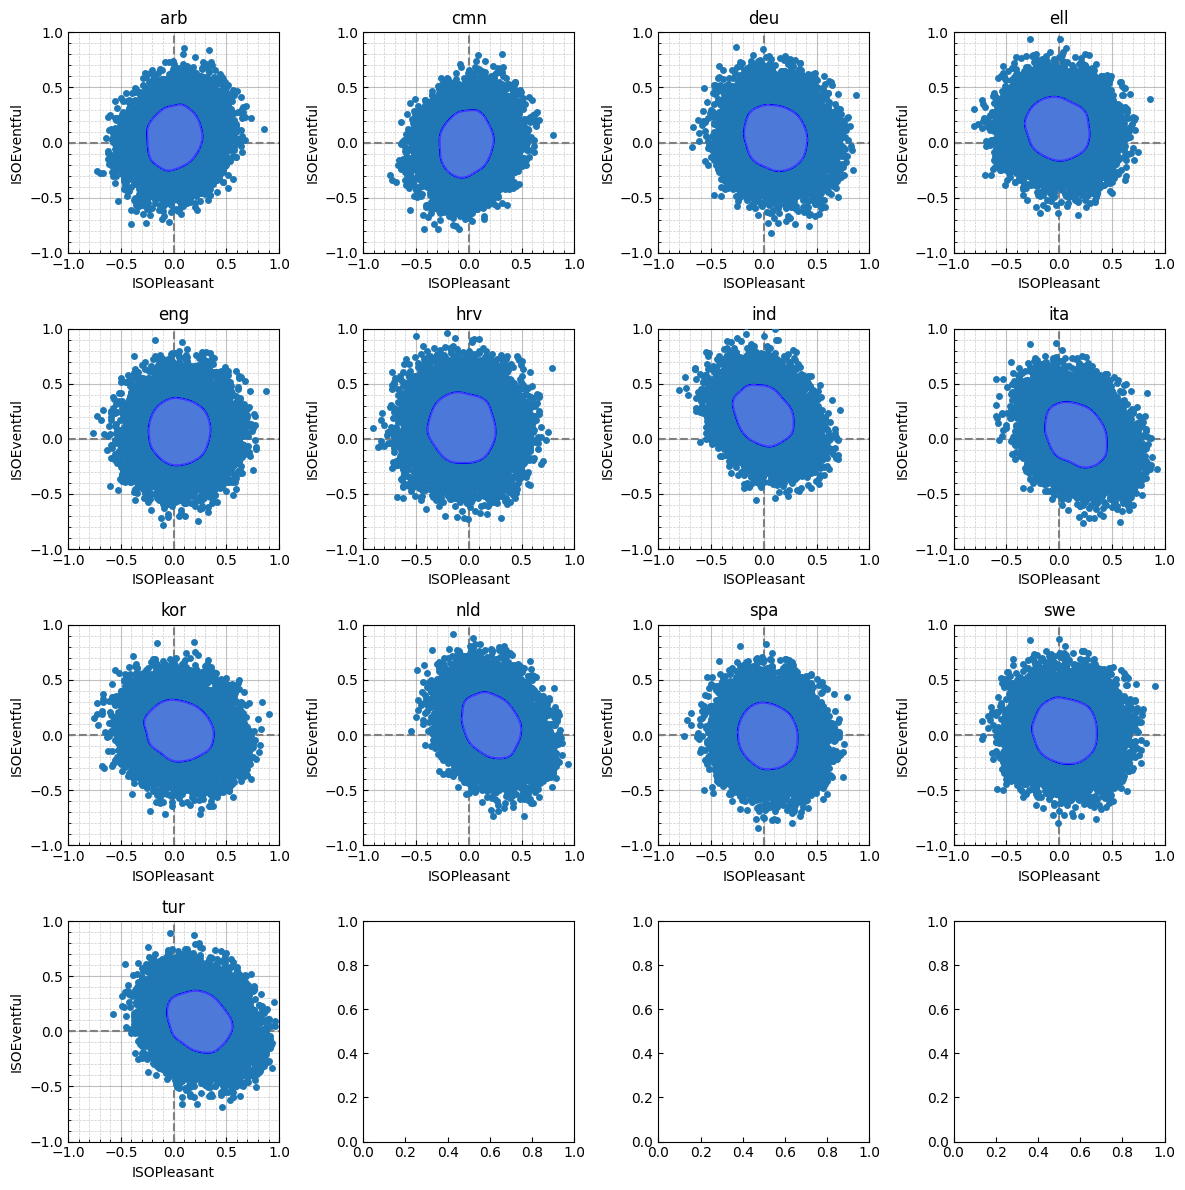

In [315]:
fig, axes = plt.subplots(4, 4, figsize=(12, 12))
for i, lang in enumerate(satp.Language.unique()):
    lang_data = sspy.surveys.simulation(n=10000, val_range=(0, 100))
    isopl, isoev = adj_angle_iso_coords(lang_data, ang_dict[lang], scale=100)
    # isopl, isoev = sspy.surveys.calculate_paq_coords(lang_data, val_range=(0,100))
    lang_res = pd.DataFrame({"ISOPleasant": isopl, "ISOEventful": isoev})
    print("=====================")
    print(lang)
    print(lang_res.min())
    print(lang_res.max())
    sspy.plotting.density(lang_res, ax=axes.flatten()[i], title=lang, density_type='simple')

plt.tight_layout()

## Final scores for circumplex translations

In [76]:
sem_res[["Language", "Model Type", "Score", "passing"]].loc[sem_res["Model Type"] == "Equal comm."].sort_values("Score", ascending=False)

pass_step_3 = congruence_df[congruence_df["Corr Ang Procrustes"] > 0.95]['Language']

passing_res = sem_res.loc[sem_res["Language"].isin(pass_step_3)]
passing_res[["Language", "Model Type", "Score", "passing"]].loc[passing_res["Model Type"] == "Equal comm."].sort_values("Score", ascending=False)

,Language,Model Type,Score,passing
1,eng,Equal comm.,3,Pass
5,arb,Equal comm.,3,Pass
9,cmn,Equal comm.,3,Pass
13,deu,Equal comm.,3,Pass
17,ell,Equal comm.,3,Pass
25,hrv,Equal comm.,3,Pass
29,ind,Equal comm.,3,Pass
33,ita,Equal comm.,3,Pass
41,kor,Equal comm.,3,Pass
45,nld,Equal comm.,3,Pass


## Using the corrected angles for ISO 12913-3 and @Mitchell2022How style analysis

Making use of these corrected angles in line with either the analysis recommended in @ISO12913Part3 or @Mitchell2022How is quite straightforward. Simply replace the $\cos{45}$ in the ISO projection equation with $\cos{\theta}$ and $\sin{\theta}$, where $\theta$ is the corrected angle for each scale.

For example, the ISO projection equation for ISOPleasant and ISOEventful in Swedish are now:

$$
P = p + \cos(66)*v + \cos(87)*e + \cos(146)*ch + \cos(175)*a + \cos(249)*m + \cos(275)*u + \cos(335)*ca
$$

$$
E = \sin(66)*v + \sin(87)*e + \sin(146)*ch + \sin(175)*a + \sin(249)*m + \sin(275)*u + \sin(335)*ca
$$

For each language, simply replace the $\theta$ values with the corrected angles for that language.

In more SEM-like terms, we are multiplying each scale by its respective loading expressed in terms of its angle around the circumplex, and then summing the results. Some may argue that we should just directly treat this system as an SEM, however by expressing this projection in terms of the angles, we can directly see how this is related to the circumplex and the projected coordinate point, and more easily compare the results with the results from the SSM analysis.

In that vein, we would actually recommend performing the ISOPleasant & ISOEventful calculations via the Structural Summary Method, rather than the projection method. This provides a more flexible and informative framework for the analysis, and allows for the correlation of the scales with external variables, calculation of model fit, and other useful analyses.

In [77]:
all_res = circumplex.ssm_analyse(satp, scales, grouping=['Recording'])
# all_res.plot()

In [78]:
lang = 'eng'
lang_res = circumplex.ssm_analyse(satp.query("Language == @lang"), scales, grouping=['Recording'])

data1, data2 = prepare_congruence_matrices(lang_res.table, all_res.table['displacement'])
print(congruence(data1, data2))

(0.9480639019729175, array([0.99948136, 0.81830281, 0.17377312, 0.98827771, 0.96188724,
       0.97766954, 0.98469718, 0.99719209, 0.99964641, 0.99455728,
       0.98389512, 0.99634407, 0.99883624, 0.99932437, 1.        ,
       0.99712412, 0.99977068, 0.99607947, 0.99865792, 0.97955141,
       0.98232248, 0.96306566, 0.89797989, 0.98831028, 0.99721633,
       0.9707336 , 0.95302897]))


## 

In [79]:
from matplotlib import colormaps

def plot_circumplex(scale, reduced_eq_results: circumplex.SSMResults, reduced_corr_results: circumplex.SSMResults):

    fig, ax = plt.subplots(1, 2, figsize=(10, 5), subplot_kw={"projection": "polar"})
    colors = colormaps.get_cmap("tab20").colors
    colors = iter(colors)

    for res in reduced_eq_res.results:
        ax[0].plot(
            np.deg2rad(res.displacement),
            res.amplitude,
            color=next(colors),
            marker="o",
            markersize=10,
            label = res.label,
        )
    ax[0].set_title("Equal Angles")

    colors = colormaps.get_cmap("tab20").colors
    colors = iter(colors)
    for res in reduced_corr_res.results:
        ax[1].plot(
            np.deg2rad(res.displacement),
            res.amplitude,
            color=next(colors),
            marker="o",
            markersize=10,
            label = res.label
        )
    ax[1].set_title("Corrected Angles")
    ax[1].legend(bbox_to_anchor=(1.1, 1.1))

    plt.suptitle(scale)
    plt.tight_layout()
